## Ocean Arctic Mean Salinity and Temperature Profiles

This notebook plots the mean profile of salinity and temperature in the Arctic Ocean  
It originated from Sonya Legg

In [12]:
import os

In [24]:
config = {
    "startyr": "2003",
    "endyr": "2017",
    #"dora_id": "odiv-403",
    "dora_id": "odiv-411",
}

for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
)

In [25]:
import glob
import subprocess
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import doralite
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"


In [26]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

auto_checkout = False

print(pathPP)

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/


In [27]:
import regionmask
basins=regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50
Arctic_index=basins.map_keys("Arctic Ocean")


PlotRegion = False
if PlotRegion:
    
    proj=ccrs.NorthPolarStereo(central_longitude=-300)
    
    plt.figure(figsize=[12,8])
    ax=plt.subplot(111,projection=proj)
    p=basins[Arctic_index,].plot(ax=ax,add_label=False)
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    p.axes.set_extent([-300, 60, 50, 90], ccrs.PlateCarree())

In [28]:

component = "ocean_annual_z"
static = f"{component}/{component}.static.nc"
varname = "*"

chunk = "annual_5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/av/{chunk}/{component}.*.nc", recursive=True))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2003-2007.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2008-2012.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2013-2017.ann.nc


In [29]:
if not "DORA_EXECUTE" in os.environ.keys():
    subprocess.run(["dmwho"])

MINUTES  USERNAME                  HOST    COMMAND FILES
   44.7  William.Cooke             pp320   dmput      77
   31.6  William.Cooke             pp048   dmput      77
    6.9  William.Cooke             pp327   dmput      77
    2.5  Jaeyeon.Lee               an012   dmget       2
    0.1  Ming.Zhao                 pp335   dmput       1
    0.1  Ming.Zhao                 pp337   dmput       1


In [30]:
if not "DORA_EXECUTE" in os.environ.keys():
    cmd = ["dmget"]+filelist+[staticfile]
    
    if auto_checkout:
        print("Calling dmget on files ...")
        _ = subprocess.check_output(cmd)
    else:
        print("Paste to terminal to dmget files ...")
        out_string=''
        for cell in cmd:
            out_string+=' '+cell
        print(out_string)

Paste to terminal to dmget files ...
 dmget /archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2003-2007.ann.nc /archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2008-2012.ann.nc /archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2013-2017.ann.nc /archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp//ocean_annual_z/ocean_annual_z.static.nc


In [31]:
ds = momgrid.Gridset(filelist, force_symmetric=False, return_corners=True)
model_type = ds.model
ds_modeldata = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))[['so','thetao','geolon','geolat','z_l']]
ds_modeldata['mask']=basins.mask(ds_modeldata.geolon,ds_modeldata.geolat)
ds_modeldata_Arctic = ds_modeldata.where(ds_modeldata['mask']==Arctic_index)
static = xr.open_dataset(staticfile)

In [32]:
#Obs File

#Used to use PHC3, updated to woa23
#PHC3dataset = xr.open_dataset(f'/archive/Raphael.Dussin/datasets/PHC3.0/phc3.0_annual.nc',engine='netcdf4')
#maskobs=basins.mask(PHC3dataset.lon,PHC3dataset.lat)

woa23dataset = xr.open_mfdataset(['/net3/bgr/Datasets/WOA/woa23_decav91C0_t00_04.nc',
                              '/net3/bgr/Datasets/WOA/woa23_decav91C0_s00_04.nc']
                              ,decode_times=False).isel(time=0)
maskwoa=basins.mask(woa23dataset.lon,woa23dataset.lat)
Arctic_maskwoa = maskwoa == Arctic_index
Arcticwoa = woa23dataset.where(Arctic_maskwoa)

#Could be improved?
def horizontal_areaweightedmean_obs(da,dalat):
    RE=6.378e3
    delta_lat = 1.0
    delta_lon = 1.0
    delta_y = (RE*(np.pi * delta_lat/180))
    delta_x = RE*(np.pi*delta_lon/180)*np.cos(np.pi*dalat/180)
    msk=1+0*da
    num = (msk*da*delta_y*delta_x).sum(dim=['lon', 'lat'])
    denom = (msk*delta_y*delta_x).sum(dim=['lon', 'lat'])
    return num / denom

Arcticmeansalinitywoa=horizontal_areaweightedmean_obs(Arcticwoa['s_an'],Arcticwoa.lat)


Text(0.5, 0, 'Salinity')

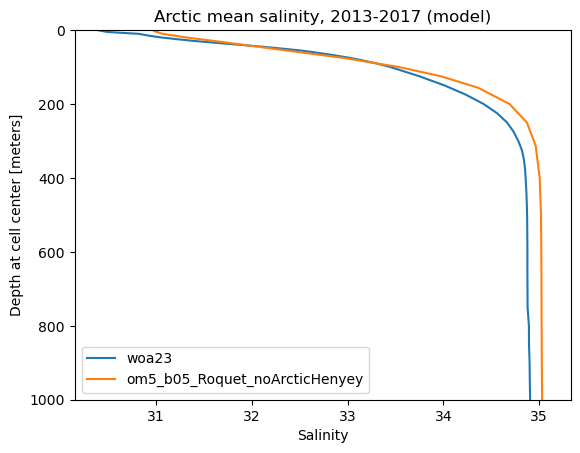

In [33]:
Arcticmeansalinitywoa=horizontal_areaweightedmean_obs(Arcticwoa['s_an'],Arcticwoa.lat)
Arcticmeansalinitywoa.plot(y='depth',ylim=(0,1000),label="woa23")
ds_modeldata_Arctic.isel(time=0).mean(dim=['xh','yh']).so.plot(y='z_l',ylim=(0,1000),label=expName)
plt.gca().invert_yaxis()
plt.title('Arctic mean salinity, 2013-2017 (model)')
plt.legend()
plt.xlabel('Salinity')

Text(0.5, 0, 'Temperature')

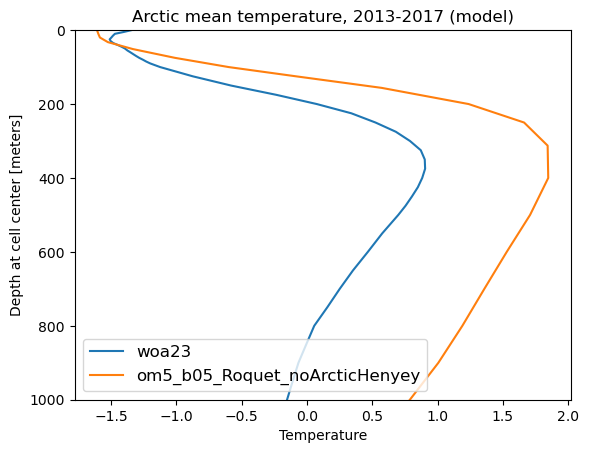

In [34]:
Arcticmeanthetawoa=horizontal_areaweightedmean_obs(Arcticwoa['t_an'],Arcticwoa.lat)
Arcticmeanthetawoa.plot(y='depth',ylim=(0,1000),label="woa23")
ds_modeldata_Arctic.isel(time=0).mean(dim=['xh','yh']).thetao.plot(y='z_l',ylim=(0,1000),label=expName)
plt.gca().invert_yaxis()
plt.title('Arctic mean temperature, 2013-2017 (model)')
plt.legend(fontsize=12)
plt.xlabel('Temperature')